<a href="https://colab.research.google.com/github/kadeng/colab_tutorials/blob/master/docs/torchdrug/TorchDrug_Basic_Usage_and_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introduction

In this tutorial, we are going to introduce the basic usage of **TorchDrug**.

### Manual Steps

1.   Get your own copy of this file via "File > Save a copy in Drive...",
2.   Set the runtime to **GPU** via "Runtime > Change runtime type..."

### Colab Tutorials

#### Quick Start
1. [Basic Usage and Pipeline](https://colab.research.google.com/drive/1Tbnr1Fog_YjkqU1MOhcVLuxqZ4DC-c8-#forceEdit=true&sandboxMode=true)

#### Drug Discovery Tasks
1. [Property Prediction](https://colab.research.google.com/drive/1sb2w3evdEWm-GYo28RksvzJ74p63xHMn?usp=sharing#forceEdit=true&sandboxMode=true)
2. [Pretrained Molecular Representations](https://colab.research.google.com/drive/10faCIVIfln20f2h1oQk2UrXiAMqZKLoW?usp=sharing#forceEdit=true&sandboxMode=true)
3. [De Novo Molecule Design](https://colab.research.google.com/drive/1JEMiMvSBuqCuzzREYpviNZZRVOYsgivA?usp=sharing#forceEdit=true&sandboxMode=true)
4. [Retrosynthesis](https://colab.research.google.com/drive/1IH1hk7K3MaxAEe5m6CFY7Eyej3RuiEL1?usp=sharing#forceEdit=true&sandboxMode=true)
5. [Knowledge Graph Reasoning](https://colab.research.google.com/drive/1-sjqQZhYrGM0HiMuaqXOiqhDNlJi7g_I?usp=sharing#forceEdit=true&sandboxMode=true)

In [ ]:
import os
import torch
os.environ["TORCH_VERSION"] = torch.__version__

!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-$TORCH_VERSION.html
!pip install wandb
!python -m pip install git+https://github.com/DeepGraphLearning/torchdrug
# !pip install torchdrug

Looking in links: https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
     |████████████████████████████████| 1.8 MB 12.2 MB/s 
     |████████████████████████████████| 145 kB 23.8 MB/s 
     |████████████████████████████████| 181 kB 51.5 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=ab771f0f61e4d1402a4b6bcaf4a1570f19f1f1f7cbc2b3b9c13ecdd4bd78449b
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Cloning https://github.com/DeepGraphLearning/torchdrug to /tmp/pip-req-build-tixh9xb8
  Running command git clone -q https://github.com/DeepGraphLearning/torchdrug /tmp/pip-req-build-tixh9xb8


# Graphs
Graphs are the fundamental data structure used in TorchDrug. They can be viewed as a generalization of graph processing libraries (e.g., NetworkX) in a tensor framework, while enjoy the GPU acceleration and auto differentiation.

The following code shows how to create a cycle graph from an edge list. By default, the graph structure is stored as an edge list to save memory consumption. We can convert it to a dense adjacency matrix on the fly if needed.

09:04:26   NumExpr defaulting to 2 threads.
tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.]])


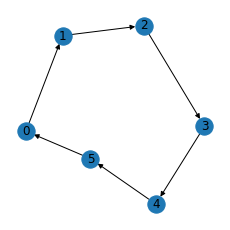

In [ ]:
import torchdrug as td
from torchdrug import data
%matplotlib inline

edge_list = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 0]]
graph = data.Graph(edge_list, num_node=6)
graph.visualize()
print(graph.adjacency.to_dense())

Graphs are defined with directed edges. To define an undirected graph, we can call the member function `Graph.undirected()` to get an undirected copy of the graph.

tensor([[0., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 1., 0.]])


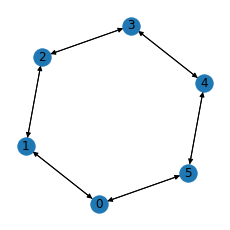

In [ ]:
graph = graph.undirected()
graph.visualize()
print(graph.adjacency.to_dense())

In some cases, we would like to specify a type for each edge in the graph. For example, we may need to represent the bond type in molecules, or the relations in biomedical knowledge graphs.

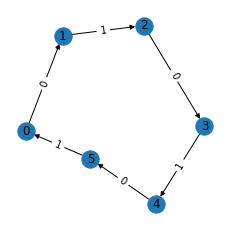

In [ ]:
edge_list = [[0, 1, 0], [1, 2, 1], [2, 3, 0], [3, 4, 1], [4, 5, 0], [5, 0, 1]]
graph = data.Graph(edge_list, num_node=6, num_relation=2)
graph.visualize()

# Molecules

A specfic instance of graphs in drug discovery is a molecule, which may have additional chemical constraints and features. For example, we can construct a molecule from SMILES string. SMILES is a language that describes complex molecule structures using a linear string.

The node and edge features may serve as input to machine learning models. We may specify different features by changing the arguments in `Molecule.from_smiles`.

Molecule(num_node=16, num_edge=32, num_relation=4)
torch.Size([16, 3])
torch.Size([32, 1])


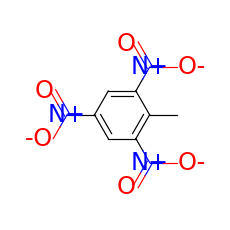

In [ ]:
smiles = "CC1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-]"
mol = data.Molecule.from_smiles(smiles, node_feature="position", edge_feature="length")
mol.visualize()
print(mol)
print(mol.node_feature.shape)
print(mol.edge_feature.shape)

The molecule data structure contains several common chemical properties. For example, we can visualize the formal charge of each atom in the molecule.

In [ ]:
for atom, charge in zip(mol.atom_type.tolist(), mol.formal_charge.tolist()):
    print("%s: %s" % (td.ATOM_SYMBOL[atom], charge))

C: 0
C: 0
C: 0
C: 0
C: 0
C: 0
C: 0
N: 1
O: 0
O: -1
N: 1
O: 0
O: -1
N: 1
O: 0
O: -1


# Knowledge Graphs

Another instance of graphs is a knowledge graph. Knowledge graphs represent biomedical knowledge as a relational graph, where each edge encodes a fact $<head, relation, tail>$.

Here we show an example of knowledge graphs with the dataset Hetionet. Hetionet has the following relations between entities.

<img src="https://het.io/about/metagraph.png" alt="Hetionet entity & relation types" width="400">

In [ ]:
from torchdrug import datasets

hetionet = datasets.Hetionet("~/knowledge-graph-datasets")
print(hetionet)

09:04:55   Downloading https://www.dropbox.com/s/y47bt9oq57h6l5k/train.txt?dl=1 to /root/knowledge-graph-datasets/hetionet_train.txt
09:05:00   Downloading https://www.dropbox.com/s/a0pbrx9tz3dgsff/valid.txt?dl=1 to /root/knowledge-graph-datasets/hetionet_valid.txt
09:05:03   Downloading https://www.dropbox.com/s/4dhrvg3fyq5tnu4/test.txt?dl=1 to /root/knowledge-graph-datasets/hetionet_test.txt


Loading /root/knowledge-graph-datasets/hetionet_train.txt: 100%|██████████| 2025177/2025177 [00:08<00:00, 235825.06it/s]
Loading /root/knowledge-graph-datasets/hetionet_valid.txt: 100%|██████████| 112510/112510 [00:00<00:00, 417531.45it/s]
Loading /root/knowledge-graph-datasets/hetionet_test.txt: 100%|██████████| 112510/112510 [00:00<00:00, 398393.21it/s]


Hetionet(
  #entity: 45158
  #relation: 24
  #triplet: 2250197
)


We visualize a single edge from the knowledge graph. This edge encodes the fact that [gene 11344](https://www.ncbi.nlm.nih.gov/gene/11344) regulates [gene 7485](https://www.ncbi.nlm.nih.gov/gene/7485).

In [ ]:
kg = hetionet.graph
h, t, r = kg.edge_list[0]
print(hetionet.entity_vocab[h], hetionet.relation_vocab[r],
      hetionet.entity_vocab[t])

Gene::11344 Gr>G Gene::7485


# Graph Operations
A group of arbitrary graphs can also be processed as a batch to maximize the utilization of hardware. They can also be transferred between CPUs and GPUs using `cpu()` and `cuda()` methods.



PackedMolecule(batch_size=4, num_nodes=[12, 6, 14, 9], num_edges=[22, 10, 30, 18], num_relation=4)


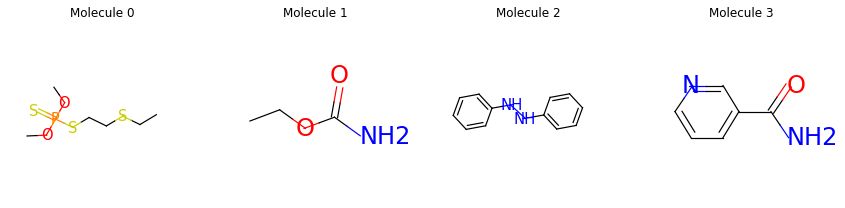

In [ ]:
smiles_list = ["CCSCCSP(=S)(OC)OC", "CCOC(=O)N",
               "N(Nc1ccccc1)c2ccccc2", "NC(=O)c1cccnc1"]
mols = data.PackedMolecule.from_smiles(smiles_list)
mols.visualize(num_row=1)
print(mols)

In [ ]:
mols = mols.cuda()
print(mols)

PackedMolecule(batch_size=4, num_nodes=[12, 6, 14, 9], num_edges=[22, 10, 30, 18], num_relation=4, device='cuda:0')


Just like original PyTorch tensors, a batch of graphs supports many common broadcast and indexing operations.

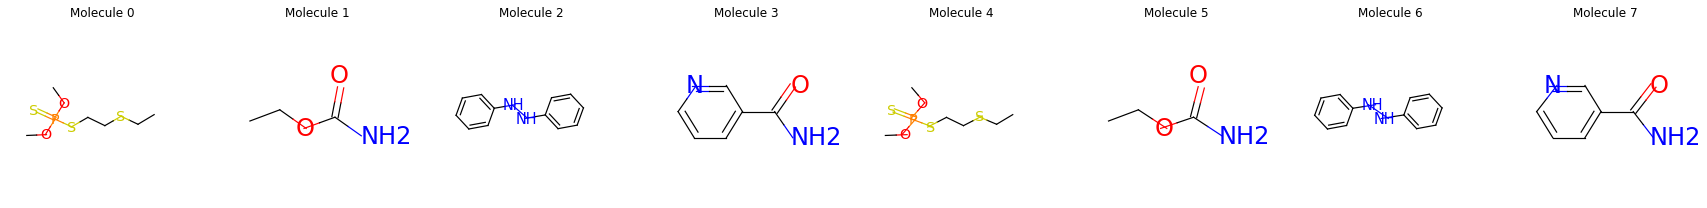

In [ ]:
mols = mols.repeat(2)
mols.visualize(num_row=1)

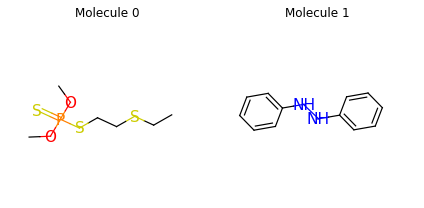

In [ ]:
mols = mols[[0, 2]]
mols.visualize()

Besides graph-level operations, there are also node-level and edge-level operations. The following example shows how to select edges that contain at least one carbon. This creates disconnected components in each molecule.



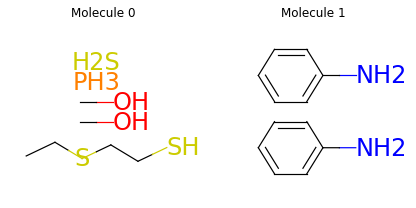

In [ ]:
node_in, node_out, bond_type = mols.edge_list.t()
edge_mask = (mols.atom_type[node_in] == td.CARBON) | \
            (mols.atom_type[node_out] == td.CARBON)
mols = mols.edge_mask(edge_mask)
mols.visualize()

We can further extract each single connected component as a separate molecule. This operation is commonly used in fragment-based drug discovery.

tensor([5, 2], device='cuda:0')
['CCSCCS', 'P', 'S', 'CO', 'CO', 'Nc1ccccc1', 'Nc1ccccc1']


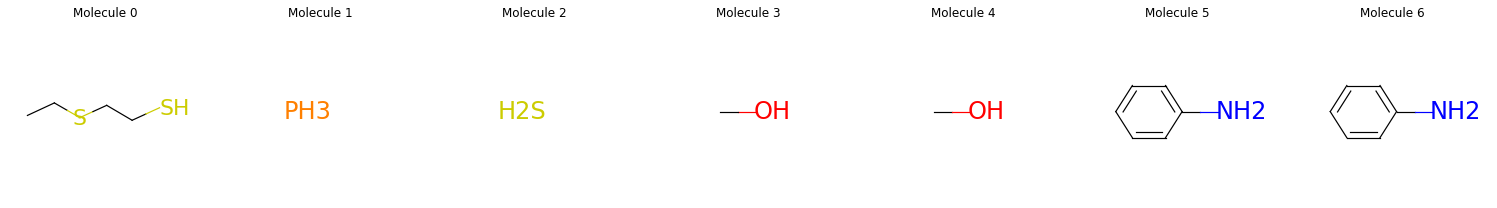

In [ ]:
mols, num_cc = mols.connected_components()
mols.visualize(num_row=1)
print(num_cc)
print(mols.to_smiles())

We may also retrieve specific edges from a graph. A typical usage of this operation is to search a knowledge graph for answering some queries.

Consider a query on Hetionet: *What are the symptoms that asthma presents?*

In [ ]:
asthma = hetionet.inv_entity_vocab["Disease::DOID:2841"]
presents = hetionet.inv_relation_vocab["DpS"]
any = -1

We can create a search pattern $<asthma, presents, ?>$, and search the knowledge graph with ``match()``.

In [ ]:
patterns = torch.tensor([[asthma, any, presents]])
edge_index, num_match = kg.match(patterns)
symptoms = kg.edge_list[edge_index, 1]
from pprint import pprint
pprint([hetionet.entity_vocab[s] for s in symptoms.tolist()])

/usr/local/lib/python3.7/dist-packages/torchdrug/data/graph.py:448: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  scale = scale[-1] // scale


['Symptom::D012135',
 'Symptom::D006935',
 'Symptom::D012913',
 'Symptom::D020078',
 'Symptom::D055154',
 'Symptom::D001049',
 'Symptom::D016857',
 'Symptom::D000472',
 'Symptom::D012893',
 'Symptom::D020181',
 'Symptom::D001724',
 'Symptom::D003490',
 'Symptom::D012912',
 'Symptom::D007040',
 'Symptom::D014832',
 'Symptom::D003371',
 'Symptom::D002637',
 'Symptom::D006685',
 'Symptom::D014202',
 'Symptom::D011602',
 'Symptom::D004417',
 'Symptom::D005311',
 'Symptom::D006985',
 'Symptom::D004418',
 'Symptom::D000860',
 'Symptom::D009058']


# Register Your Own Attributes

While the `Molecule` class comes with several chemical properties, we may also want to define our own properties. This only requires to wrap the attribute assignment lines with a context manager. The following example defines a custom node attribute to encode whether each node is connected to a carbon.

We can use `mol.edge()` and `mol.graph()` for node- and graph-level attributes respectively.


C: True
C: True
C: True
C: True
C: True
C: True
C: True
N: True
O: False
O: False
N: True
O: False
O: False
N: True
O: False
O: False


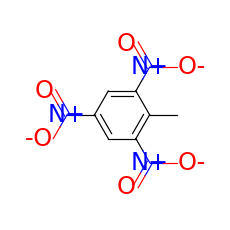

In [ ]:
from torch_scatter import scatter_add

smiles = "CC1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-]"
mol = data.Molecule.from_smiles(smiles)
node_in, node_out = mol.edge_list.t()[:2]
attached_to_C = scatter_add(mol.atom_type[node_in] == td.CARBON, node_out, dim_size=mol.num_node)
mol.visualize()
with mol.node():
    mol.attached_to_C = attached_to_C
for atom, attach in zip(mol.atom_type.tolist(), mol.attached_to_C.tolist()):
    print("%s: %s" % (td.ATOM_SYMBOL[atom], attach))

The custom attributes are preserved in all graph operations. This behaves similarly as masking operations on PyTorch tensors.

N: True
O: False
O: False
N: True
O: False
O: False
N: True
O: False
O: False


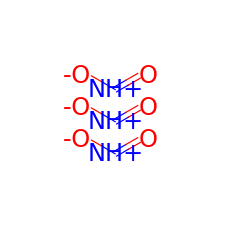

In [ ]:
mol = mol.subgraph(mol.atom_type != td.CARBON)
mol.visualize()
for atom, attach in zip(mol.atom_type.tolist(), mol.attached_to_C.tolist()):
    print("%s: %s" % (td.ATOM_SYMBOL[atom], attach))

# A Molecule Classifier
Now we demonstrate how to use TorchDrug to create a molecule classifier. Specifically, TorchDrug provides us with a large collection of popular datasets and models for drug discovery and graph representation learning. These help us avoid writing and debugging boilerplate code.

For this tutorial, we use the ClinTox dataset. This dataset requires to predict whether a molecule is toxic in clinical trials, and whether it is approved by FDA.

### Load and Prepare Dataset Splits
First of all, we load the dataset with TorchDrug. TorchDrug will automatically download the dataset into the path you specify.

We then split the dataset into train, validation and test, with a ratio of 8:1:1.

In [ ]:
import torch
from torch.nn import functional as F
from torchdrug import datasets

dataset = datasets.ClinTox("~/molecule-datasets/")
lengths = [int(0.8 * len(dataset)), int(0.1 * len(dataset))]
lengths += [len(dataset) - sum(lengths)]
train_set, valid_set, test_set = torch.utils.data.random_split(dataset, lengths)

Constructing molecules from SMILES:   0%|          | 0/1484 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `*`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Tc`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Fe`
  warnings.warn("Unknown value `%s`" % x)
/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:   8%|▊         | 112/1484 [00:00<00:03, 448.26it/s]/usr/local/lib/python3.7/dist-packages/torchdrug/data/feature.py:37: UserWarning: Unknown value `Ca`
  warnings.warn("Unknown value `%s`" % x)
Constructing molecules from SMILES:  11%|█         | 159/1484 [00:00<00:03, 400.13it/s]/usr/local/lib/python3.7/dist-packag

### Define a Graph Neural Network for Classification
We define a graph neural network to encode the molecule graphs. Specifically, we use the a Graph Isomorphism Network (GIN) with 4 hidden layers.

In [ ]:
from torchdrug import core, models, tasks

model = models.GIN(input_dim=dataset.node_feature_dim,
                   hidden_dims=[256, 256, 256, 256],
                   short_cut=True, batch_norm=True, concat_hidden=True)

Note the model is simply a neural network without any training target. To adapt it for classification, we wrap it with a property prediction module. We define the classification task by the binary cross entropy (BCE) criterion.

In [ ]:
task = tasks.PropertyPrediction(model, task=dataset.tasks,
                                criterion="bce", metric=("auprc", "auroc"))

### Train the Model
We create an optimizer for the parameters in the task, and combine everything into `core.Engine`. The engine provides convenient routines for training and test.



In [ ]:
optimizer = torch.optim.Adam(task.parameters(), lr=1e-4)
solver = core.Engine(
    task, train_set, valid_set, test_set, optimizer,
    batch_size=1024, gpus=[0], logger="wandb"
)
solver.train(num_epoch=100)

![wandb_demo.png](https://raw.githubusercontent.com/DeepGraphLearning/torchdrug/master/asset/model/wandb_demo.png)

### Test the Model
To test the model on validation set, it only takes one line.

In [ ]:
solver.evaluate("valid")

09:17:23   >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
09:17:23   Evaluate on valid
09:17:23   ------------------------------
09:17:23   auprc [CT_TOX]: 0.272013
09:17:23   auprc [FDA_APPROVED]: 0.982489
09:17:23   auroc [CT_TOX]: 0.660584
09:17:23   auroc [FDA_APPROVED]: 0.794898


{'auprc [CT_TOX]': tensor(0.2720, device='cuda:0'),
 'auprc [FDA_APPROVED]': tensor(0.9825, device='cuda:0'),
 'auroc [CT_TOX]': tensor(0.6606, device='cuda:0'),
 'auroc [FDA_APPROVED]': tensor(0.7949, device='cuda:0')}

Alternatively, we can make prediction on arbitrary input batches. The following code shows the prediction for the first 8 samples in the validation set.



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


FDA_APPROVED: tensor([0.9797, 0.9991, 0.9996, 1.0000, 0.9928, 0.9880, 0.9887, 0.9945],
       device='cuda:0', grad_fn=<UnbindBackward0>)
CT_TOX: tensor([4.2985e-02, 1.4775e-02, 5.0232e-03, 2.9617e-07, 2.0378e-02, 1.5604e-02,
        3.8220e-02, 7.9756e-03], device='cuda:0', grad_fn=<UnbindBackward0>)


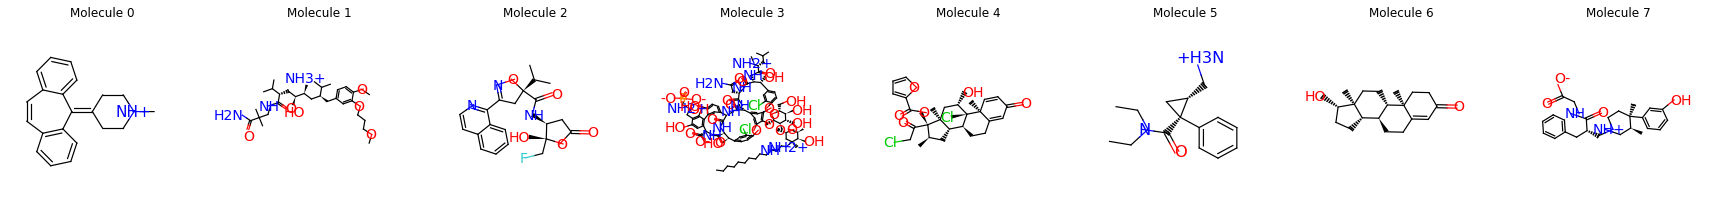

In [ ]:
from torchdrug import utils

batch = data.graph_collate(valid_set[:8])
batch["graph"].visualize(num_row=1)
batch = utils.cuda(batch, device=solver.device)
pred = F.sigmoid(task.predict(batch))
for t, p in zip(task.task, pred.t()):
    print("%s: %s" % (t, p))